In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot
print(kale.__version__)

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# ---- Create initial population

pop = holo.population.Pop_Illustris()

# ---- Apply population modifiers
redz = cosmo.a_to_z(pop.scafa)

# resample to increase the number of binaries
mod_resamp = holo.PM_Resample(resample=5.0)
# modify population (in-place)
pop.modify(mod_resamp)

redz = cosmo.a_to_z(pop.scafa)

#print(pop.mass)

hards = [
    holo.evolution.Hard_GW,
    holo.evolution.Sesana_Scattering(),
    holo.evolution.Dynamical_Friction_NFW(),
]

""" TO DO: pass acc=acc_instance to evolution,
    acc_instance is an instance of 
    acc_instance = accretion.Accretion(self, step)
    which ONLY contains the prescription to calculate the preferential accretion.
    """
acc_instance = holo.accretion.Accretion(accmod='Basic')
evo = holo.evolution.Evolution(pop, hards, debug=True, acc=acc_instance)
evo.evolve()

1.2.1


INFO:holodeck:using wider range of stellar-mass than calculated from halo-mass grid!
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 3.83e+02/1.37e+04 = 2.79e-02 `dadt` values to vcirc


evolving binaries:   0%|          | 0/99 [00:00<?, ?it/s]

INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 6.00e+00/1.37e+04 = 4.37e-04 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.00e+01/1.37e+04 = 7.28e-04 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.50e+01/1.37e+04 = 1.09e-03 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 2.20e+01/1.37e+04 = 1.60e-03 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 2.70e+01/1.37e+04 = 1.96e-03 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 3.50e+01/1.37e+04 = 2.55e-03 `da

INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside 

INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc
INFO:holodeck:clipping 1.40e+01/1.37e+04 = 1.02e-03 `mstar` values outside bounds ([ 5. 12.])!
INFO:holodeck:clipping 1.37e+04/1.37e+04 = 1.00e+00 `dadt` values to vcirc


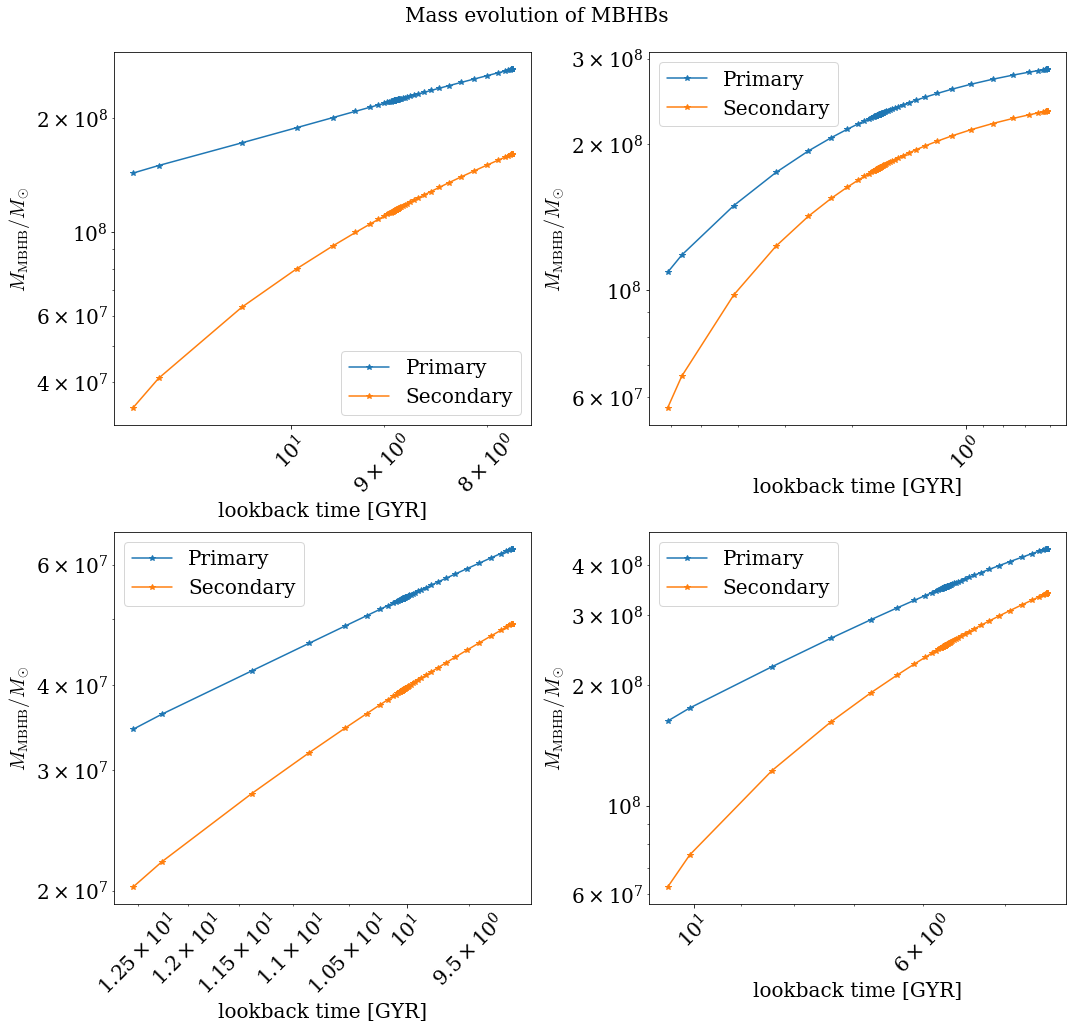

In [2]:
#Take a few random numbers and plot their mass evolutions as a function of time
import random
fs = 20

n_mbhb = evo.shape[0]

n_mbhb_to_plot = 4
inds_random_mbhb = []

p = 0
while p < n_mbhb_to_plot:
    x = random.randint(0,n_mbhb)
#     inds_random_mbhb.append(x)
#     p+=1
    inds_t_pos = evo.tlbk[x] > 0
    if len(evo.tlbk[x][inds_t_pos]) > 5:
        inds_random_mbhb.append(x)
        p += 1


fig, axs = plt.subplots(int(n_mbhb_to_plot/2),int(n_mbhb_to_plot/2),figsize=(15,15))
fig.suptitle('Mass evolution of MBHBs', fontsize=fs)
k = 0
for i in range(0,int(n_mbhb_to_plot/2)):
    for j in range(0,int(n_mbhb_to_plot/2)):
        inds_t_pos = evo.tlbk[inds_random_mbhb[k]] > 0
        time = (evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        masses = (evo.mass[inds_random_mbhb[k]][inds_t_pos])
        axs[i][j].loglog(time/GYR, masses.T[0]/MSOL, '*-', label = 'Primary')
        axs[i][j].loglog(time/GYR, masses.T[1]/MSOL, '*-', label = 'Secondary')
        axs[i][j].set_xlabel("lookback time [GYR]", fontsize=fs)
        axs[i][j].set_ylabel(r'$M_{\rm{MBHB}}/M_{\odot}$', fontsize=fs)
        k+=1
        axs[i][j].invert_xaxis()
        axs[i][j].legend(fontsize=fs)
        plt.setp(axs[i][j].get_xticklabels(which='both'), Fontsize=fs, rotation=45)
        plt.setp(axs[i][j].get_yticklabels(which='both'), Fontsize=fs)
        
plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


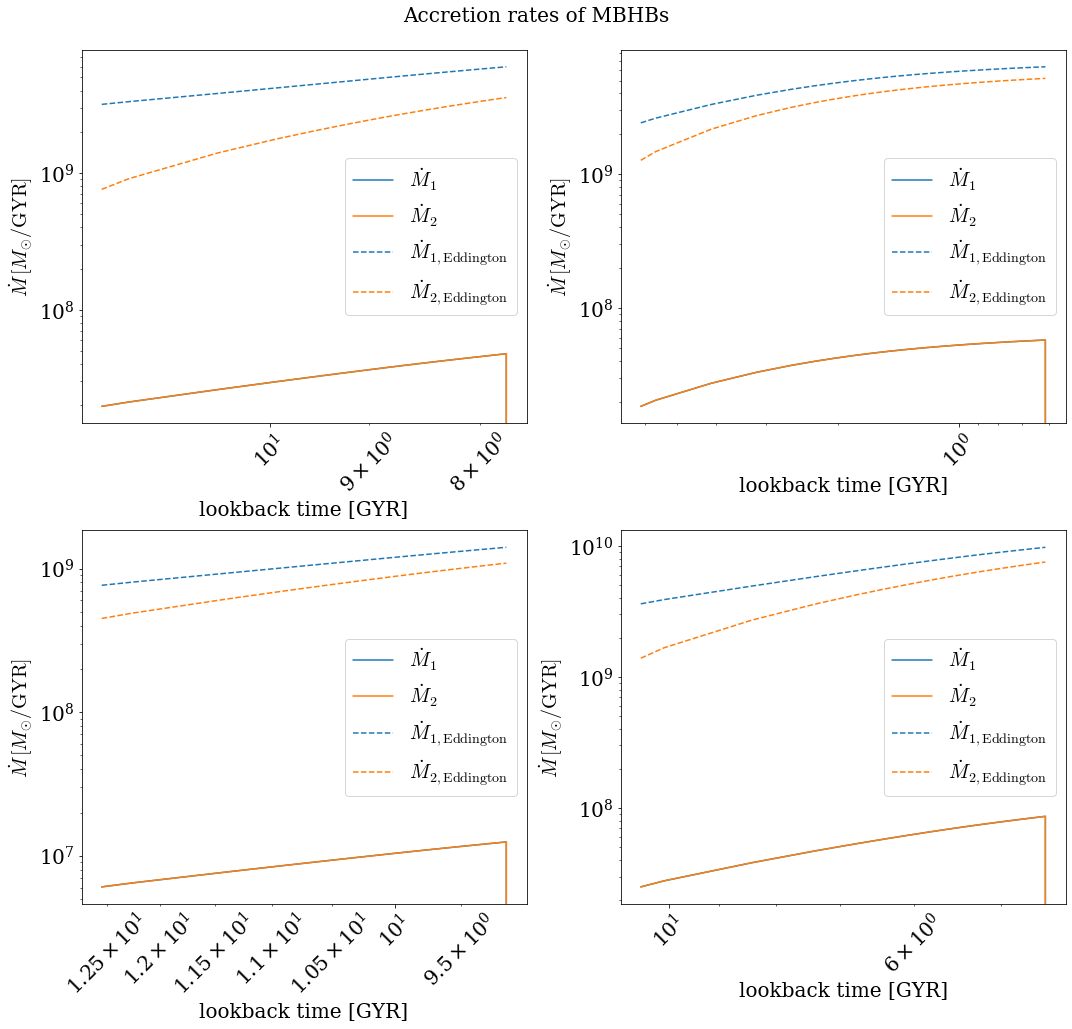

In [3]:
fig, axs = plt.subplots(int(n_mbhb_to_plot/2),int(n_mbhb_to_plot/2),figsize=(15,15))
fontsize = 20
fig.suptitle('Accretion rates of MBHBs', fontsize=fontsize)

def mdot_eddington(mass):
    from holodeck.constants import SIGMA_T, MPRT, NWTG, MSOL, SPLC
    #choose radiative efficiency epsilon = 0.1
    eps = 0.1
    medd = (4.*np.pi*NWTG*MPRT)/(eps*SPLC*SIGMA_T) * mass
    return(medd)

k = 0
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,int(n_mbhb_to_plot/2)):
    for j in range(0,int(n_mbhb_to_plot/2)):
        inds_t_pos = evo.tlbk[inds_random_mbhb[k]] > 0
        #print("evo.tlbk[inds_random_mbhb[k]][inds_t_pos] = ", evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        time = (evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        mdots = (evo.mdot[inds_random_mbhb[k]][inds_t_pos])
        masses = (evo.mass[inds_random_mbhb[k]][inds_t_pos])
        axs[i][j].loglog(time/GYR, mdots.T[0]/MSOL * GYR, '-', color = default_colors[0], label = r'$\dot{M}_1$')
        axs[i][j].loglog(time/GYR, mdots.T[1]/MSOL * GYR, '-', color = default_colors[1], label = r'$\dot{M}_2$')
        axs[i][j].loglog(time/GYR, mdot_eddington(masses.T[0])/MSOL * GYR, '--', color = default_colors[0], label = r'$\dot{M}_{1,\rm{Eddington}}$')
        axs[i][j].loglog(time/GYR, mdot_eddington(masses.T[1])/MSOL * GYR, '--', color = default_colors[1], label = r'$\dot{M}_{2,\rm{Eddington}}$')
        axs[i][j].set_xlabel("lookback time [GYR]", fontsize=fontsize)
        axs[i][j].set_ylabel(r'$ \dot{M} \, [M_{\odot}/\rm{GYR}]$', fontsize=fontsize)
        k+=1
        axs[i][j].invert_xaxis()
        axs[i][j].legend(fontsize=fontsize)
        plt.setp(axs[i][j].get_xticklabels(which='both'), Fontsize=fontsize, rotation=45)
        plt.setp(axs[i][j].get_yticklabels(which='both'), Fontsize=fontsize)
        
plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
